<a href="https://colab.research.google.com/github/Lomesh2000/DNN_MINI_PROJECT_1/blob/master/Targeted_attack_adversarial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
data = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
(X_train, y_train), (X_test, y_test) = data

In [ ]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
X_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


## Standarding the data

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Creating small CNN model

In [ ]:
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.9150 - loss: 0.2776
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.9819 - loss: 0.0547
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 145s 48ms/step - accuracy: 0.9900 - loss: 0.0317
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - accuracy: 0.9927 - loss: 0.0209
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.9941 - loss: 0.0177


In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Model accuracy on test data: {acc}")

313/313 - 3s - 10ms/step - accuracy: 0.9836 - loss: 0.0548
Model accuracy on test data: 0.9836000204086304


In [ ]:
# Select a small subset of the test data
num_samples = 50
x_test_subset = X_test[:num_samples]
y_test_subset = y_test[:num_samples]

# Add a channel dimension to the images for consistency with typical CNN inputs, even for this simple model
x_test_subset = x_test_subset[..., tf.newaxis]

In [ ]:
print('x_test_subset shape: ', x_test_subset.shape)
print('y_test_subset shape: ', y_test_subset.shape)

x_test_subset shape:  (50, 28, 28, 1)
y_test_subset shape:  (50,)


## Targeted FGSM Attack

The targeted Fast Gradient Sign Method (FGSM) is an adversarial attack that aims to slightly perturb an input image such that a pre-trained model misclassifies it as a specific target label. The attack calculates the gradient of the loss function with respect to the input image and uses the sign of this gradient to determine the direction of the perturbation.

The adversarial example $x_{adv}$ is generated using the following equation:

$x_{adv} = x - \epsilon \cdot \text{sign}(\nabla_{x} L(\theta, x, y_{target}))$

Where:
- $x$ is the original input image.
- $\epsilon$ (epsilon) is a small scalar value that controls the magnitude of the perturbation.
- $\nabla_{x} L(\theta, x, y_{target})$ is the gradient of the loss function with respect to the input image $x$, calculated using the model parameters $\theta$ and the target label $y_{target}$.
- $\text{sign}(\cdot)$ is the sign function, which returns -1, 0, or 1 based on the sign of the input.

In [ ]:
def targeted_fgsm_attack(model, input_image, input_label, target_label, epsilon=0.01):
    image = tf.cast(input_image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        # Expand dimensions of target_label to match the batch size of the prediction
        target_label_expanded = tf.expand_dims(tf.constant(target_label, dtype=tf.int32), axis=0)
        loss = loss_function(target_label_expanded, prediction)

    gradient = tape.gradient(loss, input_image)
    grad_sign = tf.sign(gradient)
    return grad_sign

## Targetting label 2 to be misclassified as 1

In [ ]:
epsilon = 0.147 # Increased epsilon
target_label = 1

adversarial_examples = []
original_indices_with_label_2 = []

for i in range(num_samples):
    original_image = x_test_subset[i:i+1]
    original_label = y_test_subset[i:i+1]

    if original_label == 2:
        # Convert numpy array to TensorFlow Tensor
        original_image_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32)

        grad_sign = targeted_fgsm_attack(model, original_image_tensor, original_label, target_label)

        adversarial_example = original_image - epsilon * grad_sign

        # Clip the values to ensure they are within the valid range [0, 1]
        adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)

        adversarial_examples.append(adversarial_example)
        original_indices_with_label_2.append(i)



In [ ]:
prediction_single = model(adversarial_examples[0])
print(np.argmax(prediction_single))

1


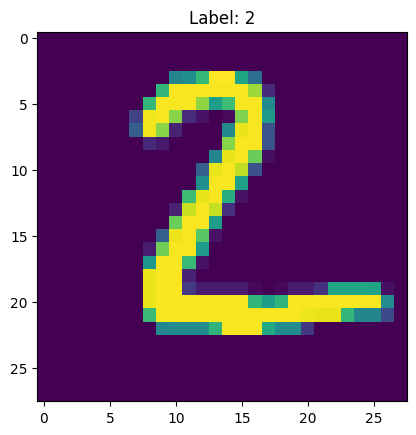

In [ ]:
plt.imshow(x_test_subset[original_indices_with_label_2[0]])
plt.title("Label: " + str(y_test_subset[original_indices_with_label_2[0]]))
plt.show()

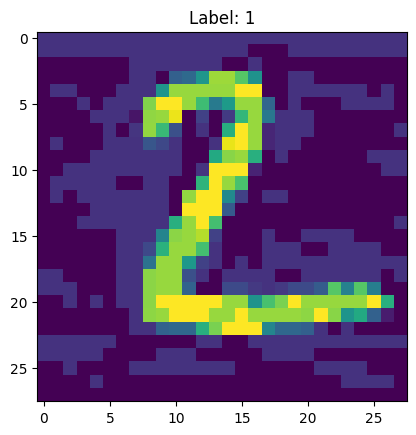

In [ ]:
plt.imshow(adversarial_examples[0].numpy()[0])
plt.title("Label: " + str(np.argmax(prediction_single)))
plt.show()

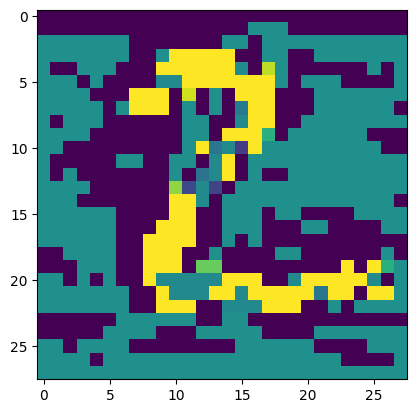

In [ ]:
plt.imshow(x_test_subset[original_indices_with_label_2[0]] - adversarial_examples[0].numpy()[0])

### Analyze Attack Success for Label 2 Images

In [ ]:
# Evaluate the adversarial examples for label 2
# Ensure the tensor has the shape (batch_size, 28, 28, 1)
predictions_adversarial_label_2 = model.predict(tf.squeeze(tf.stack(adversarial_examples), axis=1))
predicted_labels_adversarial_label_2 = np.argmax(predictions_adversarial_label_2, axis=1)

# Get the original labels for these images
original_labels_label_2 = y_test_subset[original_indices_with_label_2]

# Calculate the number of successful attacks (misclassified as the target label)
successful_attacks_count = np.sum(predicted_labels_adversarial_label_2 == target_label)

# Calculate the total number of label 2 images in the subset
total_label_2_images = len(original_indices_with_label_2)

# Calculate the attack success rate
attack_success_rate = (successful_attacks_count / total_label_2_images) * 100 if total_label_2_images > 0 else 0

print(f"Total images with original label 2 in the subset: {total_label_2_images}")
print(f"Number of successful attacks (misclassified as {target_label}): {successful_attacks_count}")
print(f"Attack success rate on label 2 images: {attack_success_rate:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 5
Attack success rate on label 2 images: 100.00%


### Visualize Original vs. Adversarial Images for Label 2

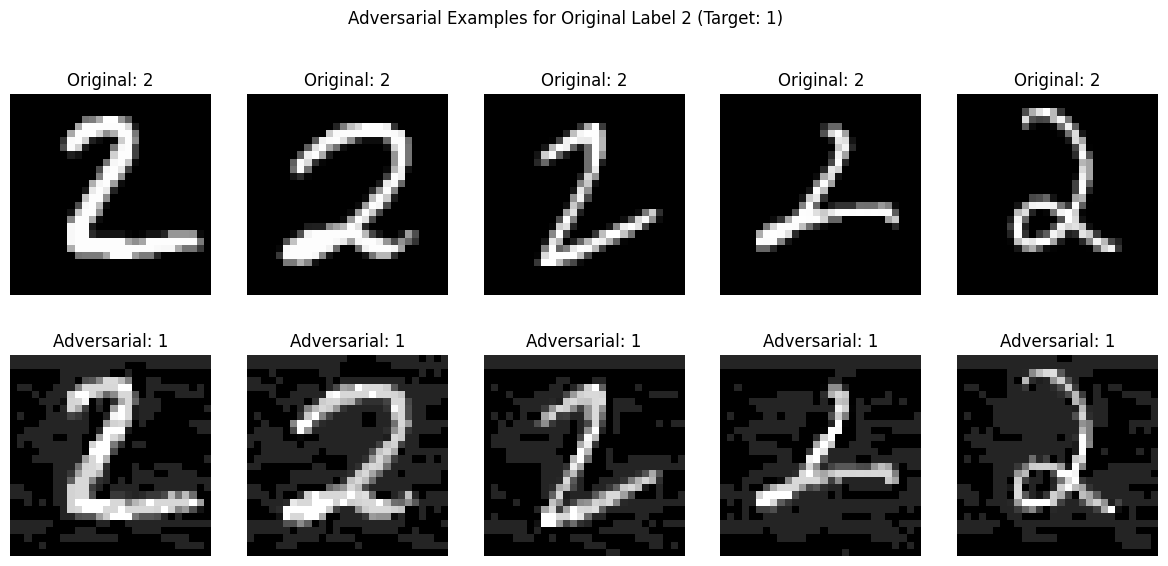

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_adversarial_examples_label_2 = len(adversarial_examples)

if num_adversarial_examples_label_2 > 0:
    # Adjust subplot creation for a single image
    if num_adversarial_examples_label_2 == 1:
        fig, ax = plt.subplots(2, 1, figsize=(3, 6))
        # Ensure ax is always an array for consistent indexing
        ax = np.array(ax).reshape(-1, 1)
    else:
        fig, ax = plt.subplots(2, num_adversarial_examples_label_2, figsize=(num_adversarial_examples_label_2 * 3, 6))

    for i in range(num_adversarial_examples_label_2):
        original_index = original_indices_with_label_2[i]
        ax[0, i].imshow(x_test_subset[original_index].squeeze(), cmap='gray')
        ax[0, i].set_title(f"Original: {y_test_subset[original_index]}")
        ax[0, i].axis('off')

        ax[1, i].imshow(adversarial_examples[i].numpy().squeeze(), cmap='gray')
        ax[1, i].set_title(f"Adversarial: {predicted_labels_adversarial_label_2[i]}")
        ax[1, i].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.suptitle(f"Adversarial Examples for Original Label 2 (Target: {target_label})", y=1.02)
    plt.show()
else:
    print("No adversarial examples generated for label 2.")

### ORiginal label 2 images and its adversarial predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 0
Attack success rate on label 2 images: 0.00%


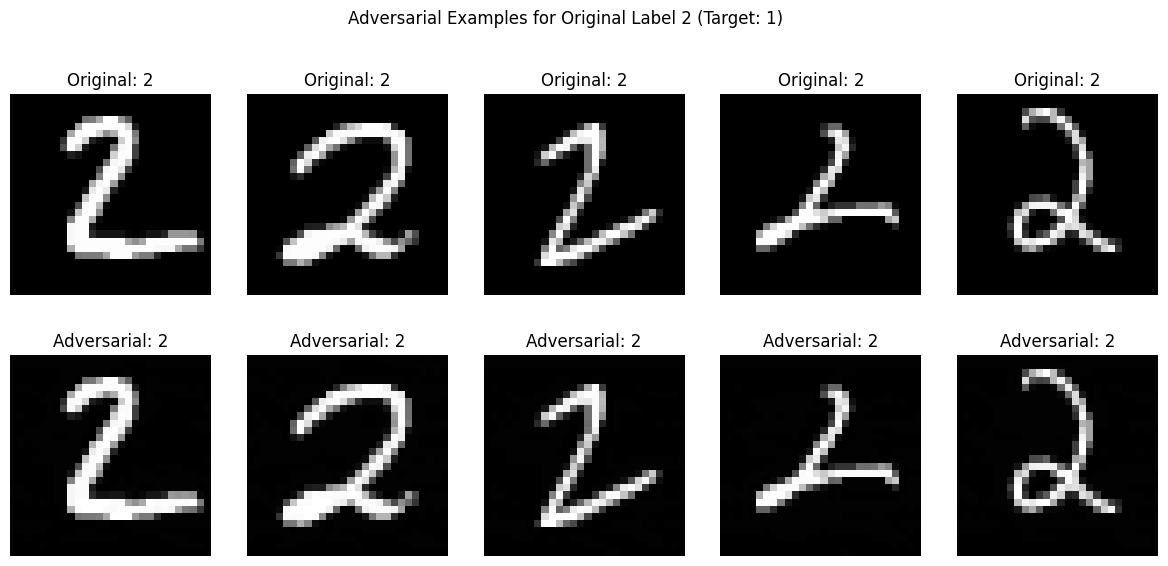

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 3
Attack success rate on label 2 images: 60.00%


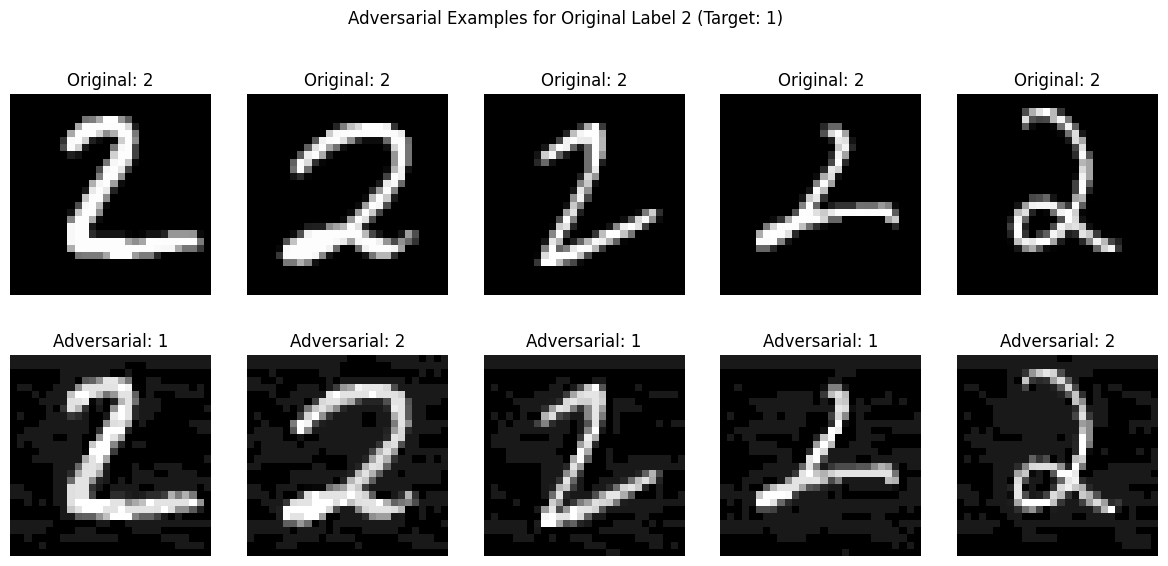

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 4
Attack success rate on label 2 images: 80.00%


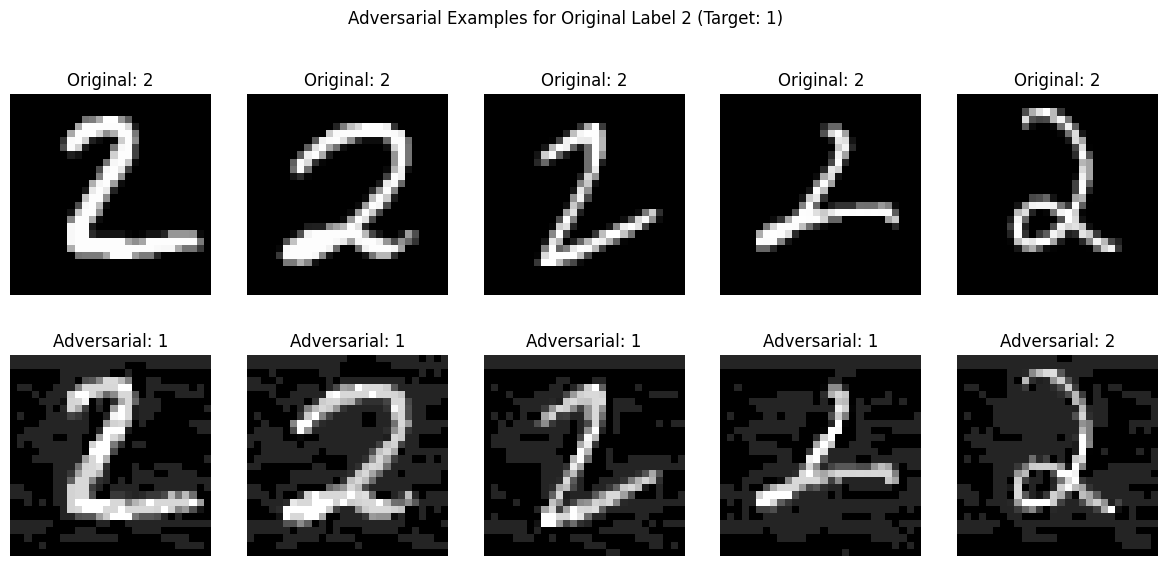

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 5
Attack success rate on label 2 images: 100.00%


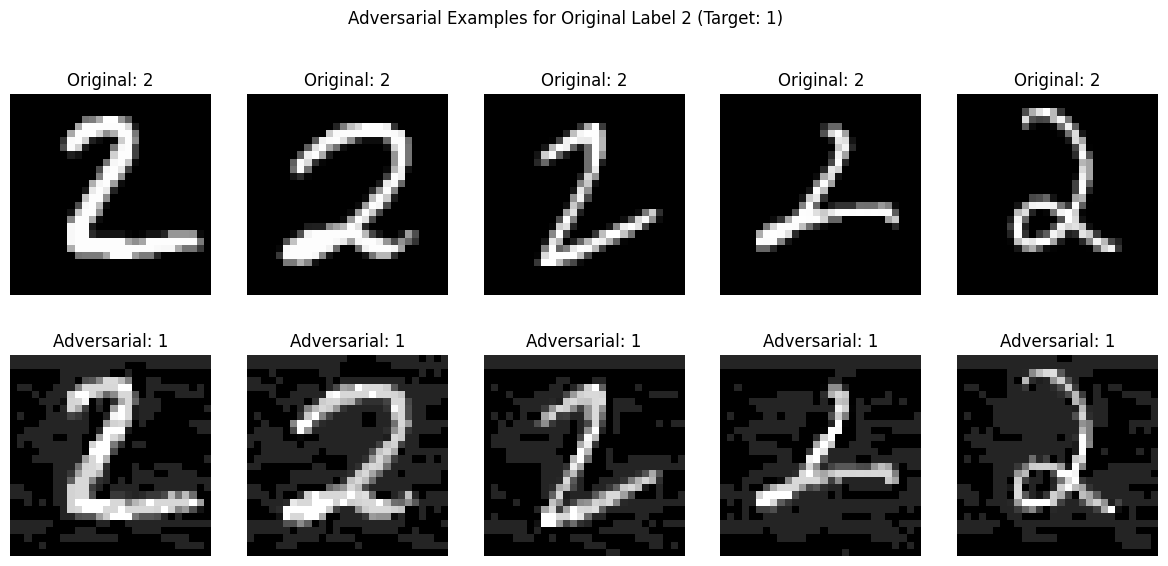

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 5
Attack success rate on label 2 images: 100.00%


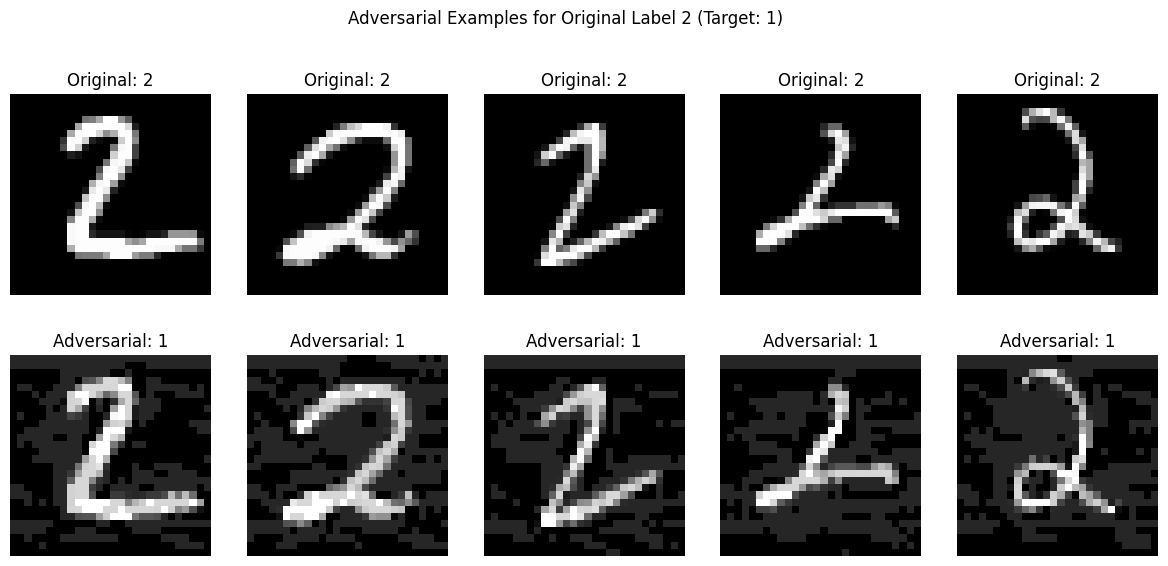

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Total images with original label 2 in the subset: 5
Number of successful attacks (misclassified as 1): 4
Attack success rate on label 2 images: 80.00%


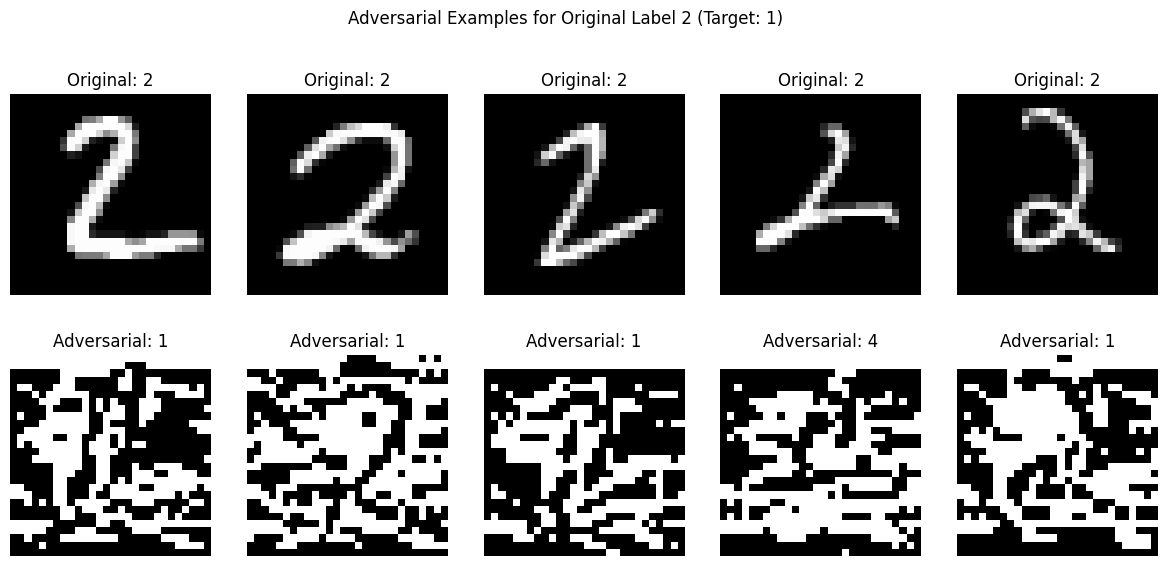

In [ ]:
epsilons = [0.01, 0.1, 0.145, 0.147, 0.15, 2]

for epsilon in epsilons:
# epsilon = 0.147 # Increased epsilon
    target_label = 1

    adversarial_examples = []
    original_indices_with_label_2 = []

    for i in range(num_samples):
        original_image = x_test_subset[i:i+1]
        original_label = y_test_subset[i:i+1]

        if original_label == 2:
            # Convert numpy array to TensorFlow Tensor
            original_image_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32)

            grad_sign = targeted_fgsm_attack(model, original_image_tensor, original_label, target_label)

            adversarial_example = original_image - epsilon * grad_sign

            # Clip the values to ensure they are within the valid range [0, 1]
            adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)

            adversarial_examples.append(adversarial_example)
            original_indices_with_label_2.append(i)


    # Evaluate the adversarial examples for label 2
    # Ensure the tensor has the shape (batch_size, 28, 28, 1)
    predictions_adversarial_label_2 = model.predict(tf.squeeze(tf.stack(adversarial_examples), axis=1))
    predicted_labels_adversarial_label_2 = np.argmax(predictions_adversarial_label_2, axis=1)

    # Get the original labels for these images
    original_labels_label_2 = y_test_subset[original_indices_with_label_2]

    # Calculate the number of successful attacks (misclassified as the target label)
    successful_attacks_count = np.sum(predicted_labels_adversarial_label_2 == target_label)

    # Calculate the total number of label 2 images in the subset
    total_label_2_images = len(original_indices_with_label_2)

    # Calculate the attack success rate
    attack_success_rate = (successful_attacks_count / total_label_2_images) * 100 if total_label_2_images > 0 else 0

    print(f"Total images with original label 2 in the subset: {total_label_2_images}")
    print(f"Number of successful attacks (misclassified as {target_label}): {successful_attacks_count}")
    print(f"Attack success rate on label 2 images: {attack_success_rate:.2f}%")



    import matplotlib.pyplot as plt
    import numpy as np

    num_adversarial_examples_label_2 = len(adversarial_examples)

    if num_adversarial_examples_label_2 > 0:
        # Adjust subplot creation for a single image
        if num_adversarial_examples_label_2 == 1:
            fig, ax = plt.subplots(2, 1, figsize=(3, 6))
            # Ensure ax is always an array for consistent indexing
            ax = np.array(ax).reshape(-1, 1)
        else:
            fig, ax = plt.subplots(2, num_adversarial_examples_label_2, figsize=(num_adversarial_examples_label_2 * 3, 6))

        for i in range(num_adversarial_examples_label_2):
            original_index = original_indices_with_label_2[i]
            ax[0, i].imshow(x_test_subset[original_index].squeeze(), cmap='gray')
            ax[0, i].set_title(f"Original: {y_test_subset[original_index]}")
            ax[0, i].axis('off')

            ax[1, i].imshow(adversarial_examples[i].numpy().squeeze(), cmap='gray')
            ax[1, i].set_title(f"Adversarial: {predicted_labels_adversarial_label_2[i]}")
            ax[1, i].axis('off')

        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        plt.suptitle(f"Adversarial Examples for Original Label 2 (Target: {target_label})", y=1.02)
        plt.show()
    else:
        print("No adversarial examples generated for label 2.")

## Epsilon vs Adversarial Success rate

In [ ]:
epsilons = [0.01, 0.1, 0.145, 0.147, 0.15, 2]
attack_success_rates = []

for epsilon in epsilons:
# epsilon = 0.147 # Increased epsilon
    target_label = 1

    adversarial_examples = []
    original_indices_with_label_2 = []

    for i in range(num_samples):
        original_image = x_test_subset[i:i+1]
        original_label = y_test_subset[i:i+1]

        if original_label == 2:
            # Convert numpy array to TensorFlow Tensor
            original_image_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32)

            grad_sign = targeted_fgsm_attack(model, original_image_tensor, original_label, target_label)

            adversarial_example = original_image - epsilon * grad_sign

            # Clip the values to ensure they are within the valid range [0, 1]
            adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)

            adversarial_examples.append(adversarial_example)
            original_indices_with_label_2.append(i)


    # Evaluate the adversarial examples for label 2
    # Ensure the tensor has the shape (batch_size, 28, 28, 1)
    predictions_adversarial_label_2 = model.predict(tf.squeeze(tf.stack(adversarial_examples), axis=1))
    predicted_labels_adversarial_label_2 = np.argmax(predictions_adversarial_label_2, axis=1)

    # Get the original labels for these images
    original_labels_label_2 = y_test_subset[original_indices_with_label_2]

    # Calculate the number of successful attacks (misclassified as the target label)
    successful_attacks_count = np.sum(predicted_labels_adversarial_label_2 == target_label)

    # Calculate the total number of label 2 images in the subset
    total_label_2_images = len(original_indices_with_label_2)

    # Calculate the attack success rate
    attack_success_rate = (successful_attacks_count / total_label_2_images) * 100 if total_label_2_images > 0 else 0

    print(f"Epsilon: {epsilon:.4f}, Attack success rate on label 2 images: {attack_success_rate:.2f}%")
    attack_success_rates.append(attack_success_rate)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epsilon: 0.0100, Attack success rate on label 2 images: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epsilon: 0.1000, Attack success rate on label 2 images: 60.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epsilon: 0.1450, Attack success rate on label 2 images: 80.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epsilon: 0.1470, Attack success rate on label 2 images: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epsilon: 0.1500, Attack success rate on label 2 images: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epsilon: 2.0000, Attack success rate on label 2 images: 80.00%


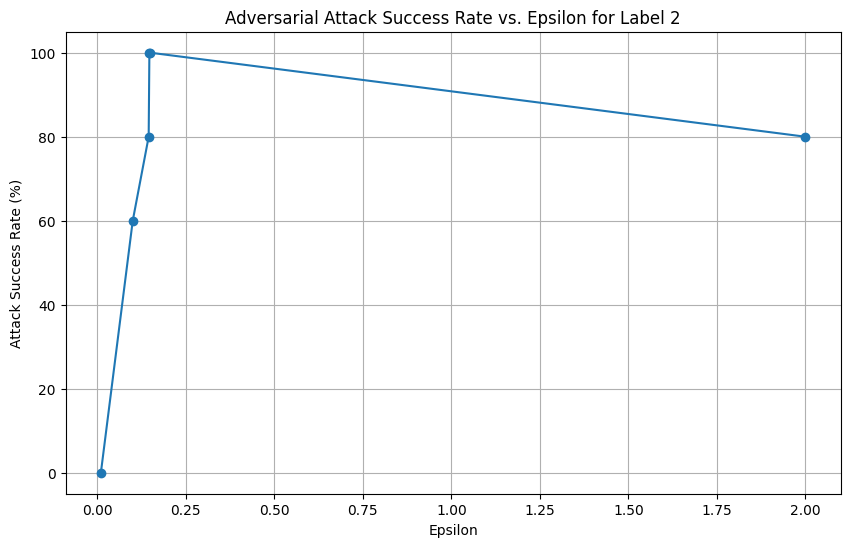

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epsilons, attack_success_rates, marker='o', linestyle='-')
plt.xlabel('Epsilon')
plt.ylabel('Attack Success Rate (%)')
plt.title('Adversarial Attack Success Rate vs. Epsilon for Label 2')
plt.grid(True)
plt.show()